In [1]:
import numpy as np
import random, copy
from scipy.stats import norm
from scipy.optimize import linprog
from math import exp,sqrt,pi
import seaborn as sns
import matplotlib.pyplot as plt
import continuous_grid_world_functions as cgw

In [2]:
# (0 UP), (1 DOWN), (2 LEFT), (3 RIGHT)

def move(i, j, a):
    if a == "L":
        i = i + random.uniform(-0.1, 0.1)
        j = j - 0.2 + random.uniform(-0.1, 0.1)

    elif a == "R":
        i = i + random.uniform(-0.1, 0.1)
        j = j + 0.2 + random.uniform(-0.1, 0.1)

    elif a == "U":
        i = i - 0.2 + random.uniform(-0.1, 0.1)
        j = j + random.uniform(-0.1, 0.1)

    else:
        i = i + 0.2 + random.uniform(-0.1, 0.1)
        j = j + random.uniform(-0.1, 0.1)

    absorbing_state = False
    # check if the new state is an absorbing state
    if i >= 0.8 and j >= 0.8:
        absorbing_state = True

    # handle boundary conditions
    if i < 0.0:
        if j < 0.0:
            i, j = 0.0, 0.0
        elif j > 1.0:
            i, j = 0.0, 1.0
        else:
            i, j = 0.0, j
    elif i > 1.0:
        if j < 0.0:
            i, j = 1.0, 0.0
        elif j > 1.0:
            i, j = 1.0, 1.0
        else:
            i, j = 1.0, j
    else:
        if j < 0.0:
            i, j = i, 0.0
        elif j > 1.0:
            i, j = i, 1.0
        else:
            i, j = i, j

    return i, j, absorbing_state

In [3]:
# function for calculating the probability density function (PDF) of a normal distribution

def calc_pdf(a, m, s):
    a = (a - m) / s
    return (exp(-(a)**2 / (2)) / (sqrt(2 * pi))) / s

In [4]:
# A=(0 UP), (1 DOWN), (2 LEFT), (3 RIGHT)
def move(i, j, a):
    # update position based on the chosen action
    if a == "L":
        i = i + random.uniform(-0.1, 0.1)
        j = j - 0.2 + random.uniform(-0.1, 0.1)

    elif a == "R":
        i = i + random.uniform(-0.1, 0.1)
        j = j + 0.2 + random.uniform(-0.1, 0.1)

    elif a == "U":
        i = i - 0.2 + random.uniform(-0.1, 0.1)
        j = j + random.uniform(-0.1, 0.1)

    else:
        i = i + 0.2 + random.uniform(-0.1, 0.1)
        j = j + random.uniform(-0.1, 0.1)

    aborbingState = False
    # check if the new state is an absorbing state
    if i >= 0.8 and j >= 0.8:
        aborbingState = True

    # handle boundary conditions
    if i < 0.0:
        if j < 0.0:
            i, j = 0.0, 0.0
        elif j > 1.0:
            i, j = 0.0, 1.0
        else:
            i, j = 0.0, j
    elif i > 1.0:
        if j < 0.0:
            i, j = 1.0, 0.0
        elif j > 1.0:
            i, j = 1.0, 1.0
        else:
            i, j = 1.0, j
    else:
        if j < 0.0:
            i, j = i, 0.0
        elif j > 1.0:
            i, j = i, 1.0
        else:
            i, j = i, j

    return i, j, aborbingState

In [5]:
# function to generate Monte Carlo trajectories

def get_monte_carlo_trajectories(p, length, count):
    trajectories = []

    # generate trajectories
    for c in range(count):
        i = 0
        j = 0
        tr = []
        tr.append([i, j])

        # generate a trajectory of 'length' steps based on the given policy
        for l in range(length-1):
            action = p[min(49, round(i*50))][min(49, round(i*50))]      # get action from the policy (bounded by 49 to prevent index errors)


            i, j, absorbing_state = move(i, j, action)            # move based on the selected action

            tr.append([i, j])

            if absorbing_state:            # check if an absorbing state is reached
                break

        trajectories.append(tr)
    return trajectories

In [6]:
# function to generate value function from trajectories

def value_function_generator(trajectories):
    val_func = []
    scale = 0.5

    for i in x_basis_mean:
        for j in y_basis_mean:
            v = 0

            # calculate value function at position (i, j) based on trajectories
            for traj in range(len(trajectories)):
                gamma_factor = 1

                # calculate value function using the product of PDFs
                for t in trajectories[traj]:
                    y, x = t[0], t[1]

                    # calculate PDFs for x and y
                    tmp_x = calc_pdf(x, i, scale)
                    tmp_y = calc_pdf(y, j, scale)

                    # update value using PDFs and gamma factor
                    v += gamma_factor * tmp_x * tmp_y
                    gamma_factor *= gamma

                # average the value over all trajectories
                v = v / len(trajectories)
                val_func.append(v)

    return val_func

In [7]:
# function to generate value function from trajectories

def value_function_generator(traj):
    val_func = []
    scale = 0.5

    for i in x_basis_mean:
        for j in y_basis_mean:
            v = 0

            # calculate value function at position (i, j) based on trajectories
            for tr in range(len(traj)):
                g = 1

                # calculate value function using the product of PDFs
                for t in traj[tr]:
                    y = t[0]
                    x = t[1]

                    # calculate PDFs for x and y
                    tmpX = calc_pdf(x, i, scale)
                    tmpY = calc_pdf(y, j, scale)

                    # update value using PDFs and gamma factor
                    v += g * tmpX * tmpY
                    g *= gamma

            # average the value over all trajectories
            v = v / len(traj)
            val_func.append(v)

    return val_func

In [8]:
# function to solve linear programming problem

def solve_lp(pred, other):

    c = [0] * (numOfBasis * numOfBasis) + [-1] * (len(other))
    A = [[0 for i in range(len(c))] for j in range(2 * len(other))]
    b = [0] * (2 * len(other))
    bound = [(-1, 1) for i in range(numOfBasis * numOfBasis)] + \
            [(None, None) for j in range(len(other))]

    # construct constraints for linear programming
    for i in range(len(other)):
        A[2 * i][numOfBasis * numOfBasis + i] = 1
        A[2 * i + 1][numOfBasis * numOfBasis + i] = 1
        for j in range(numOfBasis * numOfBasis):
            A[2 * i][j] = -1 * pred[j] + other[i][j]
            A[2 * i + 1][j] = 4 * (-1 * pred[j] + other[i][j])

    # solve the linear programming problem
    res = linprog(c, A_ub=A, b_ub=b, bounds=bound)

    return res['x']

In [9]:
# function to create a new reward matrix based on value functions and coefficients

def make_new_reward(V, alph):

    # initialize the reward matrix
    R = [[0 for ii in range(N)] for jj in range(N)]
    scale = 0.5

    # initialize variables for iterating over the state space
    x = 1 / (N * 2)
    i = 0

    # iterate over the x-axis of the state space
    while i < N:
        y = 1 / (N * 2)
        j = 0

        # iterate over the y-axis of the state space
        while j < N:
            # iterate over the basis functions
            for xm in range(len(x_basis_mean)):
                for ym in range(len(y_basis_mean)):
                    tmpX = calc_pdf(x, x_basis_mean[xm], scale)       # calculate the contribution of each basis function to the reward
                    tmpY = calc_pdf(y, y_basis_mean[ym], scale)
                    R[j][i] = alph[xm * len(x_basis_mean) + ym] * tmpX * tmpY

            y += 1 / N
            j += 1

        x += 1 / N
        i += 1

    return R      # new reward matrix

In [10]:
# function to display the policy

def showPolicy(P):
    disp = ["UP", "DOWN", "LEFT", "RIGHT"]
    print("POLICY:\n")
    for i in range(N):
        for j in range(N):
            print(P[i][j], end=" ")
        print()

# function to display the reward matrix

def showReward(R):
    print("REWARD:\n")
    for i in range(N):
        for j in range(N):
            print("%.1f" % R[i][j], end=" ")
        print()

# function to compare two policies and calculate the similarity

def comparePolicy(P, P1):
    same = 0
    for i in range(N):
        for j in range(N):
            if P1[i][j] in P[i][j]:
                same += 1
    return same / (N * N)

In [11]:
random.seed(0)
N = 50
numOfBasis = 15
gamma = 0.9

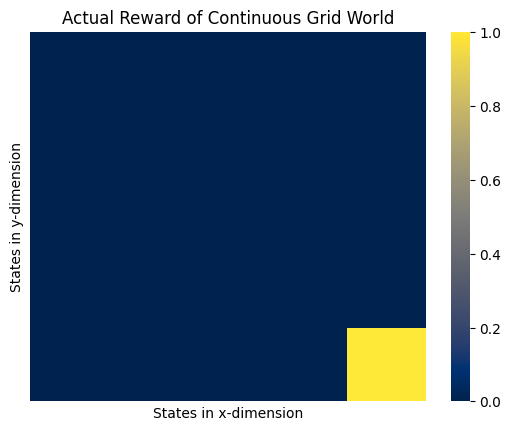

In [21]:
reward_region = round(0.8 * N)

R0 = [[0.0 for i in range(N)] for j in range(N)]

for i in range(N):
    for j in range(N):
        if i >= reward_region and j >= reward_region:
            R0[i][j] = 1.0

sns.heatmap(R0, xticklabels=False, yticklabels=False, cmap='cividis')
plt.title("Actual Reward of Continuous Grid World")
plt.xlabel("States in x-dimension")
plt.ylabel("States in y-dimension")
plt.show()

In [13]:
alphas = [0] * (numOfBasis * numOfBasis)
x_basis_mean = [i / (numOfBasis - 1) for i in range(numOfBasis - 1)] + [1.0]
y_basis_mean = [i / (numOfBasis - 1) for i in range(numOfBasis - 1)] + [1.0]

# obtaining the optimal policy
policy_predicted, equiv_poliy = cgw.get_optimal_policy(N, None)

# generating the value function using Monte Carlo trajectories
value_func_predicted = value_function_generator(get_monte_carlo_trajectories(policy_predicted, 30, 1000))

showPolicy(policy_predicted)

random_policy = [[random.choice(["U", "D", "L", "R"]) for i in range(N)] for j in range(N)]
policy_set = [random_policy]

# comparing the predicted policy with a random policy
print('\nSimilarity of predicted policy and random policy: ',comparePolicy(policy_predicted, random_policy))

POLICY:

R D R R R R D D D R D D D D R D D D D D D D R D R D D D D D D D D D D D D D D D D D D D D D D D D D 
D D D R D R R D D D D R R R D D D R D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D 
D D D R R D R D R D D D D R D D R R D R D D R D R R D D D R D D D D D D D D D D D D D D D D D D D D 
D D D D D R D D D D D D D D D D D D D R D R D D R R D D D D D D D D D D D D D D D D D D D D D D D D 
D D D D D R R D R D D D D D D R D D R R R R R R R R D D R D D D D D D D D D D D D D D D D D D D D D 
D D R D D D D D D R D D D D D D D D D R D D D D D R D D D D D D D D D D D D D D D D D D D D D D D D 
D D D D D R R R D R D D D D D R R R D R D D D R R D D D D D D D D D D D D D D D D D D D D D D D D D 
D D R R D D D R D D D D D D D R R R D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D 
D D D D D R D D D D D D D R D D D D D D D D D D D R D D D R D R R D R D D D D D D D D D D D D D D D 
D D D D D D D D R D D D D D D R D D D D D D D D D D R D R R R R R R R R R R R R D 

Generating Trajectories..

Computing Value Functions..

Solving LP..

REWARD:

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0

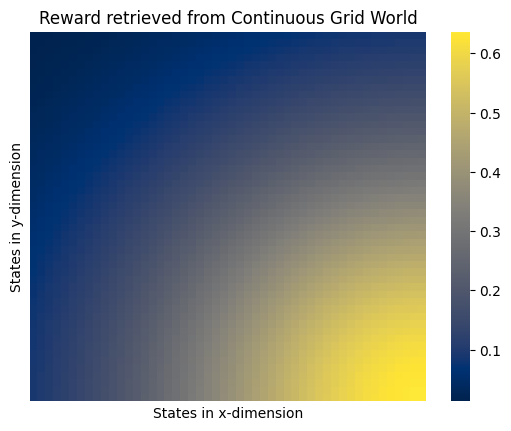

In [22]:
# initializing sets for trajectories and value functions
trajectory_set = []
value_function_set = []

print("Generating Trajectories..\n")
trajectory_set.append(get_monte_carlo_trajectories(policy_set[-1], 30, 1000))
print("Computing Value Functions..\n")
value_function_set.append(value_function_generator(trajectory_set[-1]))

print("Solving LP..\n")
# solve LP to obtain new alphas
alphas = solve_lp(value_func_predicted, value_function_set)

# make a new reward matrix using the predicted value function and the obtained alphas
R = make_new_reward(value_func_predicted, alphas)
showReward(R)
print('\n\n')

# obtain the optimal policy using LP on the new reward matrix
P, e = cgw.get_optimal_policy(N, R)
showPolicy(P)

# compare the predicted policy with the obtained policy
simlr = comparePolicy(policy_predicted, P)
print('\nSimilarity of predicted policy and obtained policy: ', simlr)
print('Error of optimal policy and optimal policy retrieved from reward = ',(1-simlr),'\n')

# append the obtained policy to the policy_set
policy_set.append(P)

# heatmap of the generated reward matrix

sns.heatmap(R, xticklabels=False, yticklabels=False, cmap='cividis')
plt.title("Reward retrieved from Continuous Grid World")
plt.xlabel("States in x-dimension")
plt.ylabel("States in y-dimension")
plt.show()